# Bishkek Real Estate Price Prediction
## Multi-Modal Model: Tabular + Image Features

This notebook implements a state-of-the-art approach combining:
- **Tabular features**: 22 engineered features from structured data
- **Image embeddings**: ResNet-50 features from property photos
- **Ensemble model**: XGBoost + LightGBM + CatBoost with Ridge meta-learner

Based on research from:
- [MHPP (arXiv 2024)](https://arxiv.org/abs/2409.05335) - Multi-Modal House Price Prediction
- [PLOS One 2024](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0321951) - ResNet-101 + Extra Trees
- [NBER Study](https://www.nber.org/papers/w25174) - Images explain 11.7% of price variance


## 1. Setup & Data Loading


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# ML
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge

# Boosting models
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Optuna for hyperparameter tuning
try:
    import optuna
    from optuna.integration import XGBoostPruningCallback, LightGBMPruningCallback
    OPTUNA_AVAILABLE = True
    print("Optuna available for hyperparameter tuning")
except ImportError:
    OPTUNA_AVAILABLE = False
    print("Optuna not available")

# For image processing (if GPU available)
try:
    import torch
    import torch.nn as nn
    import torchvision.models as models
    import torchvision.transforms as transforms
    from PIL import Image
    TORCH_AVAILABLE = True
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"PyTorch available, device: {DEVICE}")
except ImportError:
    TORCH_AVAILABLE = False
    print("PyTorch not available, skipping image features")


Optuna available for hyperparameter tuning
PyTorch available, device: cuda


## POI (Points of Interest) Data
Coordinates of key locations in Bishkek for distance-based features


In [2]:
from math import radians, sin, cos, sqrt, atan2

# POI Bishkek - key locations by category
BISHKEK_POI = {
    'bazaars': [
        ('osh_bazaar', 42.874823, 74.569599),
        ('dordoi_bazaar', 42.939732, 74.620613),
        ('ortosay_bazaar', 42.836209, 74.615931),
        ('alamedin_bazaar', 42.88683, 74.637305),
    ],
    'parks': [
        ('dubovy_park', 42.877681, 74.606759),
        ('ataturk_park', 42.839587, 74.595725),
        ('karagach_grove', 42.900362, 74.619652),
        ('victory_park', 42.826531, 74.604411),
        ('botanical_garden', 42.857152, 74.590671),
    ],
    'malls': [
        ('bishkek_park', 42.875029, 74.590403),
        ('dordoi_plaza', 42.874685, 74.618469),
        ('vefa_center', 42.857078, 74.609628),
        ('tsum', 42.876813, 74.61499),
    ],
    'universities': [
        ('auca', 42.81132, 74.627743),
        ('krsu', 42.874862, 74.627114),
        ('bhu', 42.850424, 74.585821),
        ('knu', 42.8822, 74.586638),
    ],
    'hospitals': [
        ('national_hospital', 42.869973, 74.596739),
        ('city_hospital', 42.876149, 74.5619),
    ],
    'transport': [
        ('west_bus_station', 42.873213, 74.406103),
        ('east_bus_station', 42.887128, 74.62894),
        ('railway_station', 42.864179, 74.605693),
    ],
    'admin': [
        ('jogorku_kenesh', 42.876814, 74.600155),
        ('ala_too_square', 42.875039, 74.603604),
        ('erkindik_boulevard', 42.864402, 74.605287),
    ],
}

# Premium zones - central expensive areas
BISHKEK_PREMIUM_ZONES = {
    'golden_square': (42.8688, 74.6033),
    'voentorg': (42.8722, 74.5941),
    'railway_area': (42.8650, 74.6070),
    'mossovet': (42.8700, 74.6117),
}

# City center
BISHKEK_CENTER = (42.8746, 74.5698)  # Ala-Too Square

def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate distance between two points on Earth (in km)"""
    R = 6371  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c


In [3]:
# Load data
# For Kaggle: df = pd.read_csv('/kaggle/input/bishkek-real-estate-2025/bishkek_apartments.csv')
df = pd.read_csv('/kaggle/input/bishkek-real-estate-2025/bishkek_apartments.csv')

print(f"Dataset: {len(df)} apartments, {len(df.columns)} columns")
print(f"year_built filled: {df['year_built'].notna().mean()*100:.1f}%")
print(f"JK linked: {df['residential_complex_id'].notna().mean()*100:.1f}%")


Dataset: 8821 apartments, 60 columns
year_built filled: 73.1%
JK linked: 48.9%


## 2. Feature Engineering Pipeline


In [4]:
class FeatureEngineer:
    """
    Feature engineering pipeline for real estate data.
    Handles imputation, encoding, POI distances, and derived features.

    IMPORTANT: All transformations are fit on train data only to prevent data leakage.
    """

    def __init__(self, n_district_clusters=30, include_poi=True):
        self.n_district_clusters = n_district_clusters
        self.include_poi = include_poi
        self.year_medians_by_series = None
        self.year_medians_by_type_floor = None
        self.global_year_median = None
        self.district_kmeans = None
        self.target_encodings = {}
        self.label_encoders = {}
        self.is_fitted = False

    def fit(self, df, y=None):
        """Fit all transformers on training data"""
        df = df.copy()

        # 1. Year built imputation medians
        df['floor_group'] = pd.cut(
            df['total_floors'].fillna(9),
            bins=[0, 5, 9, 12, 16, 100],
            labels=['1-5', '6-9', '10-12', '13-16', '17+']
        )

        filled = df[df['year_built'].notna()]
        self.year_medians_by_series = filled.groupby('building_series')['year_built'].median().to_dict()
        self.year_medians_by_type_floor = filled.groupby(['house_type', 'floor_group'])['year_built'].median().to_dict()
        self.global_year_median = filled['year_built'].median()

        # 2. District clustering (K-means on coordinates)
        coords = df[['latitude', 'longitude']].dropna()
        if len(coords) > self.n_district_clusters:
            self.district_kmeans = KMeans(
                n_clusters=self.n_district_clusters,
                random_state=42,
                n_init=10
            )
            self.district_kmeans.fit(coords)

        # 3. Target encoding for categorical variables (if y provided)
        if y is not None:
            df_with_target = df.copy()
            df_with_target['target'] = y

            for col in ['jk_name', 'district', 'building_series', 'house_type']:
                if col in df.columns:
                    means = df_with_target.groupby(col)['target'].mean()
                    counts = df_with_target.groupby(col)['target'].count()

                    # Smoothing with global mean
                    global_mean = y.mean()
                    smoothing = 10

                    smoothed = (means * counts + global_mean * smoothing) / (counts + smoothing)
                    self.target_encodings[col] = smoothed.to_dict()

        # 4. Label encoders for remaining categoricals
        for col in ['condition', 'heating', 'bathroom']:
            if col in df.columns:
                le = LabelEncoder()
                valid_values = df[col].dropna().unique()
                le.fit(list(valid_values) + ['unknown'])
                self.label_encoders[col] = le

        self.is_fitted = True
        return self

    def transform(self, df):
        """Transform data using fitted transformers"""
        if not self.is_fitted:
            raise ValueError("FeatureEngineer must be fitted before transform")

        df = df.copy()

        # 1. Impute year_built
        df['floor_group'] = pd.cut(
            df['total_floors'].fillna(9),
            bins=[0, 5, 9, 12, 16, 100],
            labels=['1-5', '6-9', '10-12', '13-16', '17+']
        )

        mask = df['year_built'].isna()
        for idx in df[mask].index:
            series = df.loc[idx, 'building_series']
            htype = df.loc[idx, 'house_type']
            fgroup = df.loc[idx, 'floor_group']

            if series in self.year_medians_by_series:
                df.loc[idx, 'year_built'] = self.year_medians_by_series[series]
            elif (htype, fgroup) in self.year_medians_by_type_floor:
                df.loc[idx, 'year_built'] = self.year_medians_by_type_floor[(htype, fgroup)]
            else:
                df.loc[idx, 'year_built'] = self.global_year_median

        # 2. District clusters
        if self.district_kmeans is not None:
            coords = df[['latitude', 'longitude']].fillna(df[['latitude', 'longitude']].median())
            df['district_cluster'] = self.district_kmeans.predict(coords)

        # 3. Derived features
        df['floor_ratio'] = df['floor'] / df['total_floors'].replace(0, 1)
        df['is_first_floor'] = (df['floor'] == 1).astype(int)
        df['is_last_floor'] = (df['floor'] == df['total_floors']).astype(int)
        df['building_age'] = 2025 - df['year_built']
        df['is_new_building'] = (df['year_built'] >= 2020).astype(int)
        df['area_per_room'] = df['area'] / df['rooms'].replace(0, 1)
        df['is_highrise'] = (df['total_floors'] >= 12).astype(int)

        # 4. Binary amenity features
        df['has_balcony'] = df['balcony'].notna().astype(int)
        df['has_parking'] = df['parking'].notna().astype(int)
        df['has_furniture'] = df['furniture'].notna().astype(int)

        # 5. Target encoding
        for col, encoding in self.target_encodings.items():
            if col in df.columns:
                global_mean = np.mean(list(encoding.values()))
                df[f'{col}_encoded'] = df[col].map(encoding).fillna(global_mean)

        # 6. Label encoding
        for col, le in self.label_encoders.items():
            if col in df.columns:
                df[f'{col}_encoded'] = df[col].fillna('unknown').apply(
                    lambda x: le.transform([x])[0] if x in le.classes_ else le.transform(['unknown'])[0]
                )

        # 7. House type one-hot
        if 'house_type' in df.columns:
            df['is_monolith'] = (df['house_type'] == 'монолит').astype(int)
            df['is_brick'] = (df['house_type'] == 'кирпич').astype(int)
            df['is_panel'] = (df['house_type'] == 'панель').astype(int)

        # 8. POI distances
        if self.include_poi:
            df = self._add_poi_features(df)

        return df

    def _add_poi_features(self, df):
        """Add POI distance features"""
        df = df.copy()

        # Distance to city center
        df['dist_to_center'] = df.apply(
            lambda row: haversine_distance(
                row['latitude'], row['longitude'],
                BISHKEK_CENTER[0], BISHKEK_CENTER[1]
            ) if pd.notna(row['latitude']) and pd.notna(row['longitude']) else np.nan,
            axis=1
        )

        # Distance to each POI category (minimum distance to nearest POI in category)
        for category, pois in BISHKEK_POI.items():
            col_name = f'dist_to_{category}'
            df[col_name] = df.apply(
                lambda row: self._min_distance_to_pois(row, pois),
                axis=1
            )

        # Distance to premium zones (minimum)
        df['dist_to_premium'] = df.apply(
            lambda row: self._min_distance_to_premium(row),
            axis=1
        )

        # Binary: is in premium zone (within 1km)
        df['is_premium_zone'] = (df['dist_to_premium'] <= 1.0).astype(int)

        return df

    def _min_distance_to_pois(self, row, pois):
        """Calculate minimum distance to a list of POIs"""
        if pd.isna(row['latitude']) or pd.isna(row['longitude']):
            return np.nan
        distances = [
            haversine_distance(row['latitude'], row['longitude'], lat, lon)
            for name, lat, lon in pois
        ]
        return min(distances) if distances else np.nan

    def _min_distance_to_premium(self, row):
        """Calculate minimum distance to premium zones"""
        if pd.isna(row['latitude']) or pd.isna(row['longitude']):
            return np.nan
        distances = [
            haversine_distance(row['latitude'], row['longitude'], lat, lon)
            for name, (lat, lon) in BISHKEK_PREMIUM_ZONES.items()
        ]
        return min(distances) if distances else np.nan

    def fit_transform(self, df, y=None):
        """Fit and transform in one step"""
        self.fit(df, y)
        return self.transform(df)

    def get_feature_columns(self):
        """Return list of feature columns for model"""
        base_features = [
            # Core numeric
            'latitude', 'longitude', 'area', 'rooms', 'floor', 'total_floors',
            'year_built', 'ceiling_height',

            # Derived
            'floor_ratio', 'is_first_floor', 'is_last_floor',
            'building_age', 'is_new_building', 'area_per_room', 'is_highrise',

            # Binary
            'has_balcony', 'has_parking', 'has_furniture',

            # House type
            'is_monolith', 'is_brick', 'is_panel',

            # Cluster
            'district_cluster',
        ]

        # POI distances
        if self.include_poi:
            base_features.extend([
                'dist_to_center',
                'dist_to_bazaars', 'dist_to_parks', 'dist_to_malls',
                'dist_to_universities', 'dist_to_hospitals',
                'dist_to_transport', 'dist_to_admin',
                'dist_to_premium', 'is_premium_zone',
            ])

        # Target encoded
        for col in self.target_encodings.keys():
            base_features.append(f'{col}_encoded')

        # Label encoded
        for col in self.label_encoders.keys():
            base_features.append(f'{col}_encoded')

        return base_features



## 3. Image Feature Extraction


In [5]:
class ImageFeatureExtractor:
    """
    Extract image embeddings using pretrained ResNet-50.

    Based on research:
    - ResNet-50 avgpool layer produces 2048-dim embedding
    - PCA reduction to 50-100 dimensions for efficiency
    - Mean pooling across multiple images per listing
    """

    def __init__(self, embedding_dim=50, batch_size=32):
        self.embedding_dim = embedding_dim
        self.batch_size = batch_size
        self.pca = None
        self.model = None
        self.transform = None

        if TORCH_AVAILABLE:
            # Load pretrained ResNet-50, remove classification head
            resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
            self.model = nn.Sequential(*list(resnet.children())[:-1])  # Remove FC layer
            self.model.eval()
            self.model.to(DEVICE)

            # Image preprocessing
            self.transform = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]
                )
            ])

    def extract_single_image(self, image_path):
        """Extract embedding from single image"""
        if not TORCH_AVAILABLE or self.model is None:
            return None

        try:
            img = Image.open(image_path).convert('RGB')
            img_tensor = self.transform(img).unsqueeze(0).to(DEVICE)

            with torch.no_grad():
                embedding = self.model(img_tensor)

            return embedding.squeeze().cpu().numpy()
        except Exception as e:
            return None

    def extract_listing_embedding(self, image_paths):
        """Extract mean embedding from multiple images of a listing"""
        embeddings = []

        for path in image_paths:
            emb = self.extract_single_image(path)
            if emb is not None:
                embeddings.append(emb)

        if len(embeddings) == 0:
            return np.zeros(2048)  # Return zeros if no valid images

        # Mean pooling across all images
        return np.mean(embeddings, axis=0)

    def fit(self, embeddings):
        """Fit PCA on training embeddings"""
        self.pca = PCA(n_components=self.embedding_dim, random_state=42)
        self.pca.fit(embeddings)
        return self

    def transform(self, embeddings):
        """Transform embeddings using fitted PCA"""
        if self.pca is None:
            raise ValueError("PCA must be fitted first")
        return self.pca.transform(embeddings)

    def fit_transform(self, embeddings):
        """Fit and transform in one step"""
        self.fit(embeddings)
        return self.transform(embeddings)



In [6]:
def get_image_paths(listing_id, image_dir):
    """Get all image paths for a listing"""
    listing_dir = Path(image_dir) / str(listing_id)
    if listing_dir.exists():
        return list(listing_dir.glob('*.jpg'))
    return []



## 4. Model Training


In [7]:
def calculate_metrics(y_true, y_pred):
    """Calculate regression metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    medape = np.median(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'MedAPE': medape,
        'R2': r2
    }


def print_metrics(metrics, prefix=''):
    """Pretty print metrics"""
    print(f"{prefix}MAE: ${metrics['MAE']:.2f}/m²")
    print(f"{prefix}RMSE: ${metrics['RMSE']:.2f}/m²")
    print(f"{prefix}MAPE: {metrics['MAPE']:.2f}%")
    print(f"{prefix}MedAPE: {metrics['MedAPE']:.2f}%")
    print(f"{prefix}R²: {metrics['R2']:.4f}")



In [8]:
# Prepare data
TARGET = 'price_per_m2'

# Remove outliers
df_clean = df[
    (df[TARGET] >= 500) &
    (df[TARGET] <= 5000) &
    (df['area'] >= 15) &
    (df['area'] <= 300)
].copy()

print(f"After outlier removal: {len(df_clean)} apartments")

# Split data
X = df_clean.drop(columns=[TARGET, 'price_usd', 'price_local'], errors='ignore')
y = df_clean[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")


After outlier removal: 8727 apartments
Train: 6981, Test: 1746


In [9]:
# Feature engineering
fe = FeatureEngineer(n_district_clusters=30)
X_train_fe = fe.fit_transform(X_train, y_train)
X_test_fe = fe.transform(X_test)

feature_cols = fe.get_feature_columns()
# Filter to existing columns
feature_cols = [c for c in feature_cols if c in X_train_fe.columns]

print(f"Features: {len(feature_cols)}")
print(feature_cols)


Features: 39
['latitude', 'longitude', 'area', 'rooms', 'floor', 'total_floors', 'year_built', 'ceiling_height', 'floor_ratio', 'is_first_floor', 'is_last_floor', 'building_age', 'is_new_building', 'area_per_room', 'is_highrise', 'has_balcony', 'has_parking', 'has_furniture', 'is_monolith', 'is_brick', 'is_panel', 'district_cluster', 'dist_to_center', 'dist_to_bazaars', 'dist_to_parks', 'dist_to_malls', 'dist_to_universities', 'dist_to_hospitals', 'dist_to_transport', 'dist_to_admin', 'dist_to_premium', 'is_premium_zone', 'jk_name_encoded', 'district_encoded', 'building_series_encoded', 'house_type_encoded', 'condition_encoded', 'heating_encoded', 'bathroom_encoded']


In [10]:
# Prepare final feature matrices
X_train_final = X_train_fe[feature_cols].fillna(0)
X_test_final = X_test_fe[feature_cols].fillna(0)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_test_scaled = scaler.transform(X_test_final)


## 5. Model Training & Evaluation


In [11]:
# Detect GPU availability for boosting models
USE_GPU_BOOSTING = False
USE_GPU_XGB = False
USE_GPU_LGB = False
USE_GPU_CAT = False

# Check if GPU is available (on Kaggle)
try:
    import subprocess
    result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
    if result.returncode == 0:
        print("GPU detected!")

        # Check XGBoost GPU support (try device='cuda' for XGBoost 2.0+)
        try:
            from xgboost import XGBRegressor as _XGB
            _test = _XGB(n_estimators=1, device='cuda')
            _test.fit([[1,2]], [1])
            USE_GPU_XGB = True
            print("  XGBoost GPU: Available (device='cuda')")
        except Exception as e:
            print(f"  XGBoost GPU: Not available ({e})")

        # LightGBM GPU - usually works
        USE_GPU_LGB = True
        print("  LightGBM GPU: Enabled")

        # CatBoost GPU - usually works
        USE_GPU_CAT = True
        print("  CatBoost GPU: Enabled")

        USE_GPU_BOOSTING = USE_GPU_XGB or USE_GPU_LGB or USE_GPU_CAT
except:
    pass

if not USE_GPU_BOOSTING:
    print("No GPU detected or not available. Using CPU for boosting models.")
    print("Tip: On Kaggle, enable GPU accelerator in Settings for faster training.")


GPU detected!
  XGBoost GPU: Available (device='cuda')
  LightGBM GPU: Enabled
  CatBoost GPU: Enabled


In [12]:
# Define base models with GPU support
xgb_params = {
    'n_estimators': 500,
    'max_depth': 6,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'random_state': 42,
}

# XGBoost GPU settings
if USE_GPU_XGB:
    xgb_params['device'] = 'cuda'
    xgb_params['tree_method'] = 'hist'
else:
    xgb_params['n_jobs'] = -1

lgb_params = {
    'n_estimators': 500,
    'max_depth': 6,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'random_state': 42,
    'verbose': -1
}

# LightGBM GPU settings
if USE_GPU_LGB:
    lgb_params['device'] = 'gpu'
else:
    lgb_params['n_jobs'] = -1

cat_params = {
    'iterations': 500,
    'depth': 6,
    'learning_rate': 0.05,
    'random_state': 42,
    'verbose': 0
}

# CatBoost GPU settings
if USE_GPU_CAT:
    cat_params['task_type'] = 'GPU'


In [13]:
# Train individual models
print("Training XGBoost...")
xgb_model = XGBRegressor(**xgb_params)
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)
print_metrics(calculate_metrics(y_test, xgb_pred), "XGBoost: ")

print("\nTraining LightGBM...")
lgb_model = LGBMRegressor(**lgb_params)
lgb_model.fit(X_train_scaled, y_train)
lgb_pred = lgb_model.predict(X_test_scaled)
print_metrics(calculate_metrics(y_test, lgb_pred), "LightGBM: ")

print("\nTraining CatBoost...")
cat_model = CatBoostRegressor(**cat_params)
cat_model.fit(X_train_scaled, y_train)
cat_pred = cat_model.predict(X_test_scaled)
print_metrics(calculate_metrics(y_test, cat_pred), "CatBoost: ")


Training XGBoost...
XGBoost: MAE: $127.30/m²
XGBoost: RMSE: $184.82/m²
XGBoost: MAPE: 8.17%
XGBoost: MedAPE: 5.87%
XGBoost: R²: 0.7435

Training LightGBM...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


LightGBM: MAE: $131.74/m²
LightGBM: RMSE: $190.07/m²
LightGBM: MAPE: 8.50%
LightGBM: MedAPE: 6.13%
LightGBM: R²: 0.7287

Training CatBoost...
CatBoost: MAE: $142.70/m²
CatBoost: RMSE: $203.09/m²
CatBoost: MAPE: 9.23%
CatBoost: MedAPE: 6.88%
CatBoost: R²: 0.6903


## 5.5 Optuna Hyperparameter Tuning (Optional)
Run this section to find optimal hyperparameters. Takes ~10-15 minutes.


In [14]:
def run_optuna_tuning(X_train, y_train, n_trials=50, use_gpu_xgb=False, use_gpu_lgb=False, use_gpu_cat=False):
    """
    Run Optuna hyperparameter optimization for XGBoost, LightGBM, and CatBoost.
    Returns best parameters for each model.
    """
    if not OPTUNA_AVAILABLE:
        print("Optuna not available, using default parameters")
        return None, None, None

    print("Starting Optuna hyperparameter tuning...")
    print(f"GPU: XGBoost={use_gpu_xgb}, LightGBM={use_gpu_lgb}, CatBoost={use_gpu_cat}")
    optuna.logging.set_verbosity(optuna.logging.WARNING)

    # XGBoost objective
    def xgb_objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
            'random_state': 42,
        }
        if use_gpu_xgb:
            params['device'] = 'cuda'
            params['tree_method'] = 'hist'
        else:
            params['n_jobs'] = -1

        model = XGBRegressor(**params)
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=1 if use_gpu_xgb else -1)
        return -scores.mean()

    # LightGBM objective
    def lgb_objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 15, 63),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
            'random_state': 42,
            'verbose': -1
        }
        if use_gpu_lgb:
            params['device'] = 'gpu'
        else:
            params['n_jobs'] = -1

        model = LGBMRegressor(**params)
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=1 if use_gpu_lgb else -1)
        return -scores.mean()

    # CatBoost objective
    def cat_objective(trial):
        params = {
            'iterations': trial.suggest_int('iterations', 100, 1000),
            'depth': trial.suggest_int('depth', 4, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
            'random_state': 42,
            'verbose': 0
        }
        if use_gpu_cat:
            params['task_type'] = 'GPU'

        model = CatBoostRegressor(**params)
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=1 if use_gpu_cat else -1)
        return -scores.mean()

    # Run optimization for each model
    print("\n[1/3] Tuning XGBoost...")
    xgb_study = optuna.create_study(direction='minimize')
    xgb_study.optimize(xgb_objective, n_trials=n_trials, show_progress_bar=True)
    xgb_best = xgb_study.best_params
    xgb_best.update({'random_state': 42, 'n_jobs': -1})
    print(f"  Best MAE: ${-xgb_study.best_value:.2f}/m²")

    print("\n[2/3] Tuning LightGBM...")
    lgb_study = optuna.create_study(direction='minimize')
    lgb_study.optimize(lgb_objective, n_trials=n_trials, show_progress_bar=True)
    lgb_best = lgb_study.best_params
    lgb_best.update({'random_state': 42, 'n_jobs': -1, 'verbose': -1})
    print(f"  Best MAE: ${-lgb_study.best_value:.2f}/m²")

    print("\n[3/3] Tuning CatBoost...")
    cat_study = optuna.create_study(direction='minimize')
    cat_study.optimize(cat_objective, n_trials=n_trials, show_progress_bar=True)
    cat_best = cat_study.best_params
    cat_best.update({'random_state': 42, 'verbose': 0})
    print(f"  Best MAE: ${-cat_study.best_value:.2f}/m²")

    print("\nOptuna tuning complete!")
    return xgb_best, lgb_best, cat_best


In [15]:
# Run Optuna tuning (set USE_OPTUNA = True to enable)
USE_OPTUNA = True

if USE_OPTUNA and OPTUNA_AVAILABLE:
    xgb_params_opt, lgb_params_opt, cat_params_opt = run_optuna_tuning(
        X_train_scaled, y_train, n_trials=30,
        use_gpu_xgb=USE_GPU_XGB, use_gpu_lgb=USE_GPU_LGB, use_gpu_cat=USE_GPU_CAT
    )

    if xgb_params_opt:
        print("\n" + "="*50)
        print("OPTIMIZED PARAMETERS:")
        print("="*50)
        print(f"\nXGBoost best params: {xgb_params_opt}")
        print(f"\nLightGBM best params: {lgb_params_opt}")
        print(f"\nCatBoost best params: {cat_params_opt}")

        # Update params for ensemble
        xgb_params = xgb_params_opt
        lgb_params = lgb_params_opt
        cat_params = cat_params_opt

        # Retrain with optimized parameters
        print("\nRetraining with optimized parameters...")
        xgb_model = XGBRegressor(**xgb_params)
        xgb_model.fit(X_train_scaled, y_train)
        xgb_pred = xgb_model.predict(X_test_scaled)
        print_metrics(calculate_metrics(y_test, xgb_pred), "XGBoost (Optimized): ")

        lgb_model = LGBMRegressor(**lgb_params)
        lgb_model.fit(X_train_scaled, y_train)
        lgb_pred = lgb_model.predict(X_test_scaled)
        print_metrics(calculate_metrics(y_test, lgb_pred), "\nLightGBM (Optimized): ")

        cat_model = CatBoostRegressor(**cat_params)
        cat_model.fit(X_train_scaled, y_train)
        cat_pred = cat_model.predict(X_test_scaled)
        print_metrics(calculate_metrics(y_test, cat_pred), "\nCatBoost (Optimized): ")


Starting Optuna hyperparameter tuning...
GPU: XGBoost=True, LightGBM=True, CatBoost=True

[1/3] Tuning XGBoost...


  0%|          | 0/30 [00:00<?, ?it/s]

  Best MAE: $-127.01/m²

[2/3] Tuning LightGBM...


  0%|          | 0/30 [00:00<?, ?it/s]

  Best MAE: $-130.61/m²

[3/3] Tuning CatBoost...


  0%|          | 0/30 [00:00<?, ?it/s]

  Best MAE: $-134.00/m²

Optuna tuning complete!

OPTIMIZED PARAMETERS:

XGBoost best params: {'n_estimators': 851, 'max_depth': 10, 'learning_rate': 0.026555886596801175, 'subsample': 0.948856870739707, 'colsample_bytree': 0.7749391970085768, 'min_child_weight': 6, 'reg_alpha': 9.363331009342725e-07, 'reg_lambda': 6.4593680405801604e-06, 'random_state': 42, 'n_jobs': -1}

LightGBM best params: {'n_estimators': 999, 'max_depth': 11, 'learning_rate': 0.07472845271340012, 'num_leaves': 41, 'subsample': 0.881023843120524, 'colsample_bytree': 0.7571621611382131, 'reg_alpha': 0.00011350481254187023, 'reg_lambda': 0.0031616541949666893, 'random_state': 42, 'n_jobs': -1, 'verbose': -1}

CatBoost best params: {'iterations': 393, 'depth': 10, 'learning_rate': 0.06615773812871178, 'l2_leaf_reg': 0.003366706640496286, 'random_state': 42, 'verbose': 0}

Retraining with optimized parameters...
XGBoost (Optimized): MAE: $123.82/m²
XGBoost (Optimized): RMSE: $182.19/m²
XGBoost (Optimized): MAPE: 7.92

In [16]:
# Ensemble with stacking
print("\nTraining Stacking Ensemble...")

estimators = [
    ('xgb', XGBRegressor(**xgb_params)),
    ('lgb', LGBMRegressor(**lgb_params)),
    ('cat', CatBoostRegressor(**cat_params))
]

stacking = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(alpha=1.0),
    cv=5,
    n_jobs=-1
)

stacking.fit(X_train_scaled, y_train)
ensemble_pred = stacking.predict(X_test_scaled)

print("\n" + "="*50)
print("ENSEMBLE RESULTS:")
print("="*50)
print_metrics(calculate_metrics(y_test, ensemble_pred))



Training Stacking Ensemble...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



ENSEMBLE RESULTS:
MAE: $122.96/m²
RMSE: $181.21/m²
MAPE: 7.87%
MedAPE: 5.47%
R²: 0.7534


## 6. Feature Importance


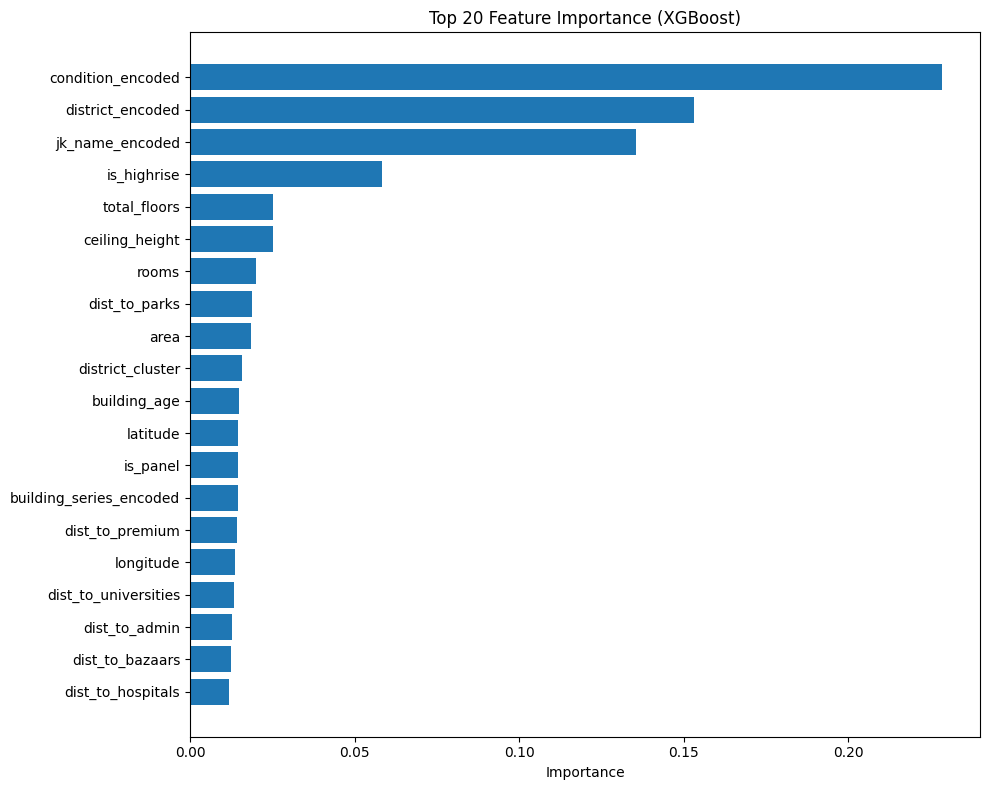

In [17]:
# Plot feature importance from XGBoost
importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=True).tail(20)

plt.figure(figsize=(10, 8))
plt.barh(importance['feature'], importance['importance'])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importance (XGBoost)')
plt.tight_layout()
plt.show()


## 7. Image Features (Optional - requires GPU)


In [18]:
# This section extracts image embeddings and adds them to features
# Uncomment and run on Kaggle with GPU enabled

"""
if TORCH_AVAILABLE:
    print("Extracting image embeddings...")

    image_dir = '/kaggle/input/bishkek-real-estate-2025/images/bishkek'
    img_extractor = ImageFeatureExtractor(embedding_dim=50)

    # Extract embeddings for all listings
    train_embeddings = []
    for listing_id in tqdm(X_train['listing_id']):
        paths = get_image_paths(listing_id, image_dir)
        emb = img_extractor.extract_listing_embedding(paths)
        train_embeddings.append(emb)

    train_embeddings = np.array(train_embeddings)

    # Fit PCA and transform
    train_img_features = img_extractor.fit_transform(train_embeddings)

    # Do same for test
    test_embeddings = []
    for listing_id in tqdm(X_test['listing_id']):
        paths = get_image_paths(listing_id, image_dir)
        emb = img_extractor.extract_listing_embedding(paths)
        test_embeddings.append(emb)

    test_embeddings = np.array(test_embeddings)
    test_img_features = img_extractor.transform(test_embeddings)

    # Combine with tabular features
    X_train_combined = np.hstack([X_train_scaled, train_img_features])
    X_test_combined = np.hstack([X_test_scaled, test_img_features])

    # Retrain ensemble with image features
    print("\\nTraining with image features...")
    stacking_img = StackingRegressor(
        estimators=estimators,
        final_estimator=Ridge(alpha=1.0),
        cv=5,
        n_jobs=-1
    )
    stacking_img.fit(X_train_combined, y_train)
    ensemble_img_pred = stacking_img.predict(X_test_combined)

    print("\\n" + "="*50)
    print("ENSEMBLE + IMAGES RESULTS:")
    print("="*50)
    print_metrics(calculate_metrics(y_test, ensemble_img_pred))
"""


'\nif TORCH_AVAILABLE:\n    print("Extracting image embeddings...")\n\n    image_dir = \'/kaggle/input/bishkek-real-estate-2025/images/bishkek\'\n    img_extractor = ImageFeatureExtractor(embedding_dim=50)\n\n    # Extract embeddings for all listings\n    train_embeddings = []\n    for listing_id in tqdm(X_train[\'listing_id\']):\n        paths = get_image_paths(listing_id, image_dir)\n        emb = img_extractor.extract_listing_embedding(paths)\n        train_embeddings.append(emb)\n\n    train_embeddings = np.array(train_embeddings)\n\n    # Fit PCA and transform\n    train_img_features = img_extractor.fit_transform(train_embeddings)\n\n    # Do same for test\n    test_embeddings = []\n    for listing_id in tqdm(X_test[\'listing_id\']):\n        paths = get_image_paths(listing_id, image_dir)\n        emb = img_extractor.extract_listing_embedding(paths)\n        test_embeddings.append(emb)\n\n    test_embeddings = np.array(test_embeddings)\n    test_img_features = img_extractor.transf

## 8. Save Results


In [19]:
# Save predictions
results = pd.DataFrame({
    'actual': y_test,
    'predicted': ensemble_pred,
    'error': y_test - ensemble_pred,
    'error_pct': (y_test - ensemble_pred) / y_test * 100
})

results.to_csv('predictions.csv', index=False)
print("Predictions saved to predictions.csv")

# Save model metrics
final_metrics = calculate_metrics(y_test, ensemble_pred)
print("\nFinal Model Performance:")
print(f"  MAE: ${final_metrics['MAE']:.2f}/m²")
print(f"  MedAPE: {final_metrics['MedAPE']:.2f}%")
print(f"  R²: {final_metrics['R2']:.4f}")


Predictions saved to predictions.csv

Final Model Performance:
  MAE: $122.96/m²
  MedAPE: 5.47%
  R²: 0.7534
